Import trainning

In [182]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import random
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [183]:
torch.cuda.is_available()

True

In [184]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [185]:
class NPZDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir  # e.g., "dataset/train/" or "dataset/val/"
        self.transform = transform  # Optional data transformations
        self.classes = ['no', 'sphere', 'vort']  # Your class names
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}  # Maps class names to indices (e.g., 'no': 0, 'sphere': 1, 'vort': 2)
        self.samples = self._load_samples()  # List of (file_path, label) pairs

    def _load_samples(self):
        samples = []
        for cls_name in self.classes:
            cls_dir = os.path.join(self.root_dir, cls_name)  # e.g., "dataset/train/no/"
            for file_name in os.listdir(cls_dir):
                if file_name.endswith('.npy'):  # Only process .npy files
                    file_path = os.path.join(cls_dir, file_name)
                    samples.append((file_path, self.class_to_idx[cls_name]))
        return samples

    def __len__(self):
        return len(self.samples)  # Total number of samples

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]  # Get file path and label for the given index
        data = np.load(file_path)  # Load the .npy file as a NumPy array
        data = torch.from_numpy(data).float()  # Convert to PyTorch tensor and ensure float type
        # if idx < 5:  # Print for first 5 samples
        #     print(f"Sample {idx} - Min: {data.min().item()}, Max: {data.max().item()}")
        if self.transform:
            data = self.transform(data)  # Apply any transformations if specified
        return data, label  # Return the data and its label

In [186]:
train_dir = "dataset/train/"  # Path to training data
val_dir = "dataset/val/"      # Path to validation data

Category: no
Sample file: dataset/train/no\1.npy
Image shape: (1, 150, 150)
Adjusted image shape: (150, 150)

Category: sphere
Sample file: dataset/train/sphere\1.npy
Image shape: (1, 150, 150)
Adjusted image shape: (150, 150)

Category: vort
Sample file: dataset/train/vort\1.npy
Image shape: (1, 150, 150)
Adjusted image shape: (150, 150)



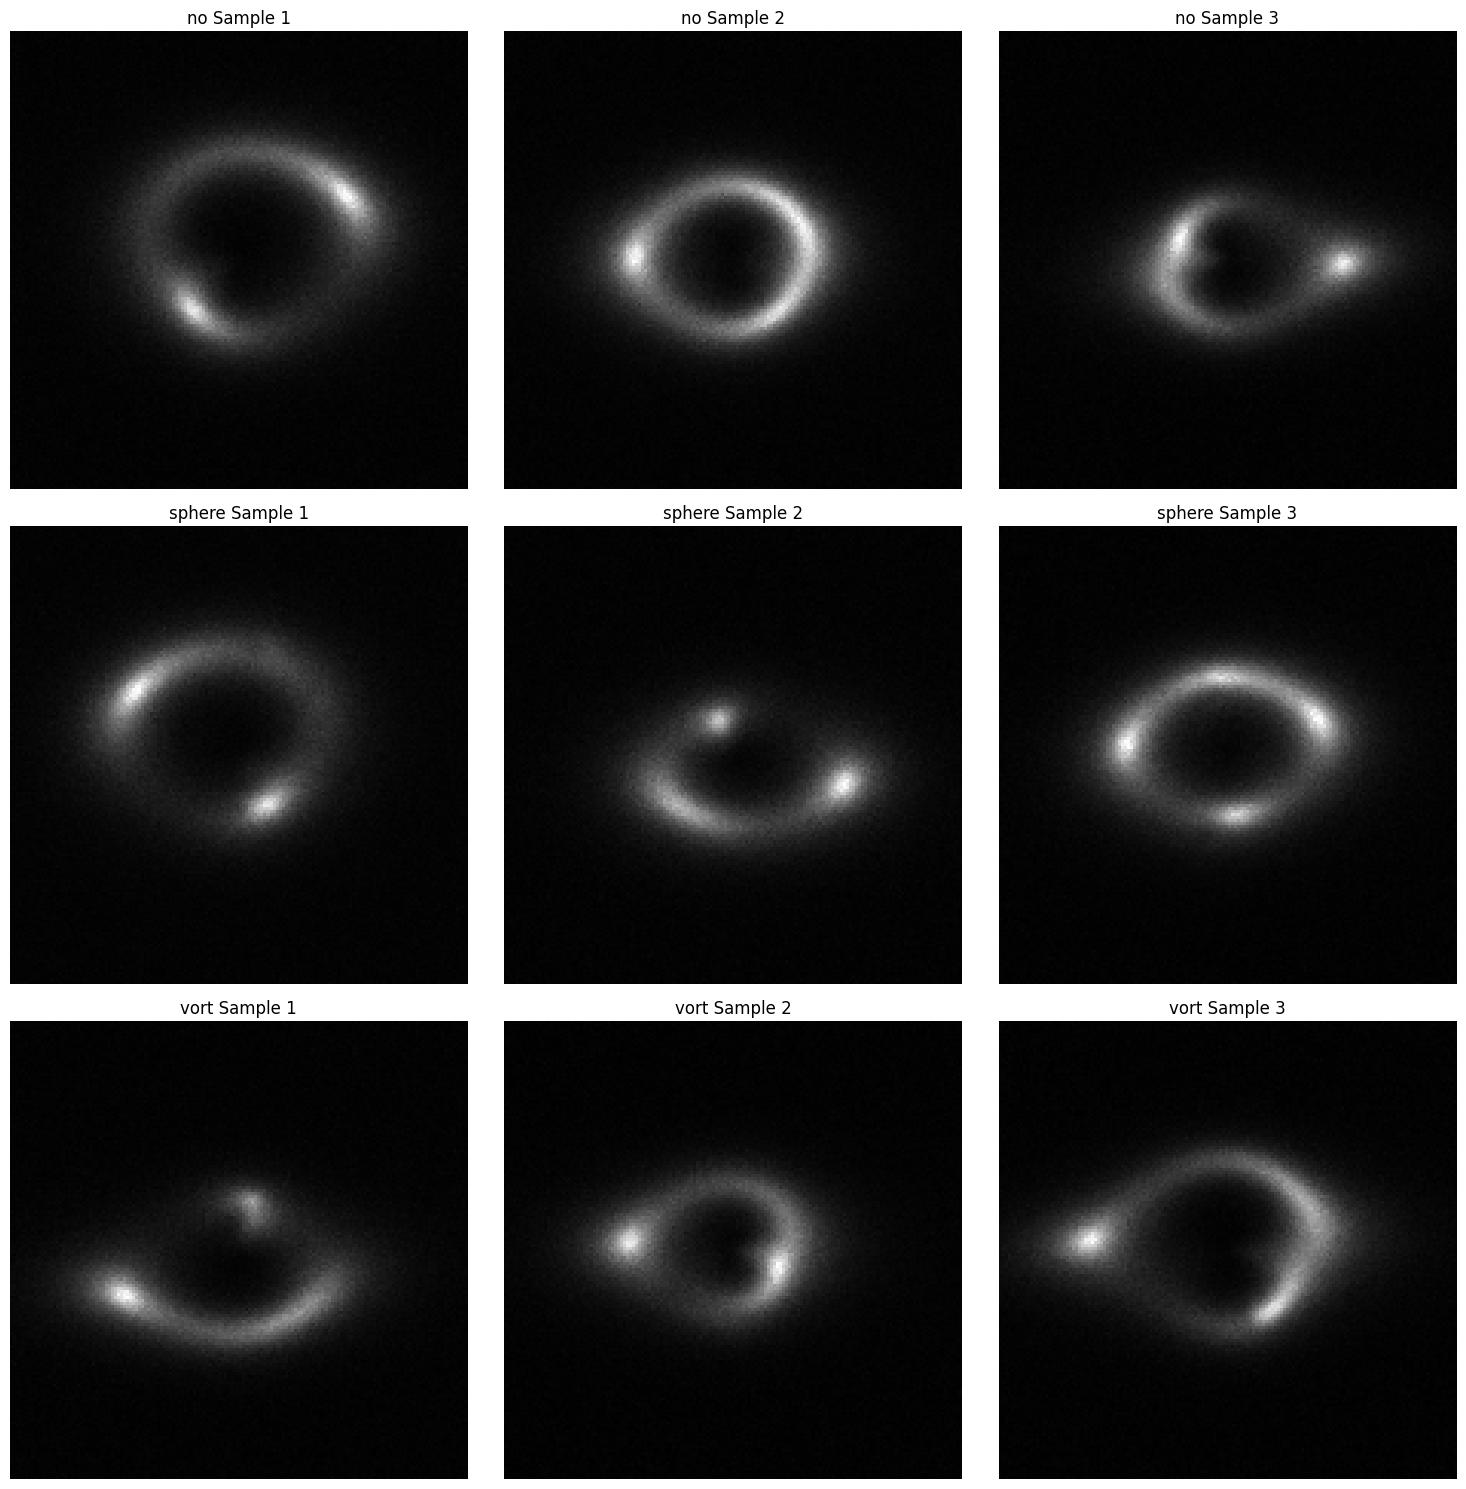

In [187]:
# Categories to preview
categories = ['no', 'sphere', 'vort']
num_images_per_class = 3  # Number of images to show per class

# Set up the subplot grid: 3 rows (one per class), 3 columns (images per class)
fig, axes = plt.subplots(nrows=len(categories), ncols=num_images_per_class, figsize=(15, 5 * len(categories)))

# Loop through each category and display images
for i, category in enumerate(categories):
    # Get the list of .npy files for this category
    category_dir = os.path.join(train_dir, category)
    image_files = [f for f in os.listdir(category_dir) if f.endswith('.npy')]
    
    # Select the first `num_images_per_class` files (or fewer if not enough files)
    image_files = image_files[:min(num_images_per_class, len(image_files))]
    
    # Load and display each image
    for j, image_file in enumerate(image_files):
        # Load the .npy file
        file_path = os.path.join(category_dir, image_file)
        image_data = np.load(file_path)  # Shape: (1, 150, 150)
        image_2d = image_data[0]  # Shape: (150, 150)
        
        # Plot the image
        ax = axes[i, j]
        ax.imshow(image_2d, cmap='gray')
        ax.set_title(f"{category} Sample {j+1}")
        ax.axis('off')
        
        # Print shape info for the first image in each category
        if j == 0:
            print(f"Category: {category}")
            print(f"Sample file: {file_path}")
            print(f"Image shape: {image_data.shape}")
            print(f"Adjusted image shape: {image_2d.shape}\n")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [188]:
# Define training transforms (augmentation + normalization)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),      # Randomly rotate by up to 10 degrees
    transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else torch.zeros_like(x)),  # Normalize to [0, 1]
])

# Define test/validation transforms (normalization only)
test_transform = transforms.Compose([
    transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else torch.zeros_like(x)),  # Normalize to [0, 1]
])

In [189]:
# Load full train and val datasets
full_train_dataset = NPZDataset(root_dir=train_dir, transform=train_transform)
val_dataset = NPZDataset(root_dir=val_dir, transform=None)

In [190]:
# Split train into 90% train and 10% test
train_size = int(0.9 * len(full_train_dataset))
test_size = len(full_train_dataset) - train_size
train_dataset, test_dataset = random_split(full_train_dataset, [train_size, test_size])

In [191]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check sizes
print(f"Full train dataset size: {len(full_train_dataset)}")
print(f"Train split size: {len(train_dataset)} (90%)")
print(f"Test split size: {len(test_dataset)} (10%)")
print(f"Validation size: {len(val_dataset)}")

Full train dataset size: 30000
Train split size: 27000 (90%)
Test split size: 3000 (10%)
Validation size: 7500


Train

In [192]:
# BasicBlock for ResNet-18
class BasicBlock(nn.Module):
    expansion = 1  # No expansion in ResNet-18's BasicBlock

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = F.relu(out)
        return out

# ResNet-18 backbone with an additional physics (psi) head.
class PINNResNetLens(nn.Module):
    def __init__(self, block, layers, num_classes=3):
        super(PINNResNetLens, self).__init__()
        self.in_channels = 64
        # Initial conv layer: note input is 1-channel (e.g., grayscale lens images)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet-18 layers
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)  # 2 blocks
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)  # 2 blocks
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)  # 2 blocks
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)  # 2 blocks

        # Classification head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # Physics (psi) head: Predict gravitational potential map ψ
        # (The output psi will have shape [batch_size, 1, H, W])
        self.psi_conv = nn.Conv2d(512 * block.expansion, 1, kernel_size=1)

    def _make_layer(self, block, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Shared feature extraction
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Classification branch
        cls = self.avgpool(x)
        cls = torch.flatten(cls, 1)
        cls = self.fc(cls)

        # Physics branch: predict lensing potential ψ
        psi = self.psi_conv(x)
        return cls, psi

    def compute_deflection(self, psi):
        """
        Compute the deflection field using the gravitational lensing equation:
            beta = theta - alpha,
        where the deflection angle alpha is given by the gradient of the potential psi.
        Here, we compute the spatial gradients in x and y directions.
        """
        # Compute gradients using finite differences.
        # Note: We pad the tensor to keep the dimensions.
        grad_x = psi[:, :, :, 1:] - psi[:, :, :, :-1]
        grad_x = F.pad(grad_x, (0, 1, 0, 0), mode='replicate')
        grad_y = psi[:, :, 1:, :] - psi[:, :, :-1, :]
        grad_y = F.pad(grad_y, (0, 0, 0, 1), mode='replicate')
        # The deflection field (alpha) has 2 channels: one for each spatial dimension.
        alpha = torch.cat([grad_x, grad_y], dim=1)
        return alpha

# Convenience function to instantiate the model with ResNet-18 layers.
def PINNResNet18(num_classes=3):
    return PINNResNetLens(BasicBlock, [2, 2, 2, 2], num_classes)

In [193]:
def total_variation(x):
    """
    Compute the total variation loss for a tensor x.
    The loss is defined as the sum of absolute differences between neighboring pixels.
    
    Args:
        x (torch.Tensor): Tensor of shape [batch_size, channels, height, width].
        
    Returns:
        torch.Tensor: Scalar tensor representing the total variation loss.
    """
    # Compute difference along the height (vertical differences)
    tv_h = torch.abs(x[:, :, 1:, :] - x[:, :, :-1, :]).sum()
    # Compute difference along the width (horizontal differences)
    tv_w = torch.abs(x[:, :, :, 1:] - x[:, :, :, :-1]).sum()
    
    # Total variation loss is the sum of both
    return tv_h + tv_w


In [ ]:
# Initialize model, loss, and optimizer
device = torch.device("mps") # mps for Apple Silicon, cuda for Nvidia GPU, cpu for CPU
# model = CNN().to(device)
model = PINNResNet18(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [195]:
# Create checkpoint directory
checkpoint_dir = "checkpoint/"
os.makedirs(checkpoint_dir, exist_ok=True)  # Create directory if it doesn't exist

In [196]:
# Training loop with validation and checkpointing
num_epochs = 90
checkpoint_interval = 5  # Save every x epochs
lambda_tv = 0.01
best_val_acc = 0.0  # Track the best validation accuracy
best_model_path = os.path.join(checkpoint_dir, "best_model.pth")

In [197]:
# Load the best model if it exists
if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}")
    checkpoint = torch.load(best_model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # scheduler.load_state_dict(checkpoint['scheduler_state_dict']) 
    best_val_acc = checkpoint['val_accuracy']
    print(f"Loaded best model with Val Accuracy: {best_val_acc:.2f}%")
else:
    print("No best model found, starting from scratch.")

Loading best model from checkpoint/best_model.pth
Loaded best model with Val Accuracy: 58.96%


In [198]:
# Optionally, load the latest checkpoint to resume training (uncomment if needed)

# # Function to find the latest checkpoint
# def find_latest_checkpoint(checkpoint_dir):
#     checkpoints = [f for f in os.listdir(checkpoint_dir) if f.startswith("checkpoint_epoch_") and f.endswith(".pth")]
#     if not checkpoints:
#         return None
#     latest_checkpoint = max(checkpoints, key=lambda x: int(x.split("_epoch_")[1].split(".pth")[0]))
#     return os.path.join(checkpoint_dir, latest_checkpoint)

# latest_checkpoint_path = find_latest_checkpoint(checkpoint_dir)
# if latest_checkpoint_path:
#     print(f"Resuming training from latest checkpoint: {latest_checkpoint_path}")
#     checkpoint = torch.load(latest_checkpoint_path, map_location=device)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
#     start_epoch = checkpoint['epoch'] + 1
#     best_val_acc = checkpoint['val_accuracy']
#     print(f"Resuming from epoch {start_epoch} with Val Accuracy: {best_val_acc:.2f}%")
# else:
#     print("No checkpoint found, starting from epoch 1.")

In [199]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # Forward pass returns classification output and potential (psi)
        cls_out, psi = model(images)
        
        # Compute classification loss
        loss_class = criterion(cls_out, labels)
        
        # Compute physics loss (e.g., total variation loss on psi)
        loss_phys = total_variation(psi)  # Ensure you have a defined total_variation function
        
        # Combined loss: classification loss + weighted physics loss
        loss = loss_class + lambda_tv * loss_phys
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(cls_out, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Validation loop: use classification branch only
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            cls_out, _ = model(images)  # Ignore psi for validation
            loss = criterion(cls_out, labels)
            val_loss += loss.item()
            _, predicted = torch.max(cls_out, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate accuracies
    train_acc = 100 * correct / total
    val_acc = 100 * val_correct / val_total

    # Step the scheduler
    scheduler.step()

    # Print metrics
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_acc:.2f}%")
    print(f"Learning Rate: {scheduler.get_last_lr()[0]}")

    # Save checkpoint every `checkpoint_interval` epochs
    if (epoch + 1) % checkpoint_interval == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss / len(train_loader),
            'val_loss': val_loss / len(val_loader),
            'val_accuracy': val_acc,
        }, checkpoint_path)
        print(f"Saved checkpoint to {checkpoint_path}")

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss / len(train_loader),
            'val_loss': val_loss / len(val_loader),
            'val_accuracy': val_acc,
        }, best_model_path)
        print(f"Saved best model to {best_model_path} with Val Accuracy: {val_acc:.2f}%")


Epoch [1/90]
Train Loss: 0.9315, Train Accuracy: 52.56%
Val Loss: 0.9069, Val Accuracy: 54.55%
Learning Rate: 0.0001
Epoch [2/90]
Train Loss: 0.9060, Train Accuracy: 54.66%
Val Loss: 0.8649, Val Accuracy: 56.20%
Learning Rate: 0.0001
Epoch [3/90]
Train Loss: 0.8858, Train Accuracy: 56.04%
Val Loss: 1.1373, Val Accuracy: 48.12%
Learning Rate: 0.0001
Epoch [4/90]
Train Loss: 0.8540, Train Accuracy: 58.26%
Val Loss: 1.0427, Val Accuracy: 43.92%
Learning Rate: 0.0001
Epoch [5/90]
Train Loss: 0.8325, Train Accuracy: 59.88%
Val Loss: 1.0710, Val Accuracy: 50.17%
Learning Rate: 0.0001
Saved checkpoint to checkpoint/checkpoint_epoch_5.pth
Epoch [6/90]
Train Loss: 0.7956, Train Accuracy: 62.34%
Val Loss: 0.9148, Val Accuracy: 57.25%
Learning Rate: 0.0001
Epoch [7/90]
Train Loss: 0.7731, Train Accuracy: 63.80%
Val Loss: 0.8081, Val Accuracy: 62.05%
Learning Rate: 0.0001
Saved best model to checkpoint/best_model.pth with Val Accuracy: 62.05%
Epoch [8/90]
Train Loss: 0.7444, Train Accuracy: 65.65%

KeyboardInterrupt: 

In [200]:
# Save the final model
final_model_path = os.path.join(checkpoint_dir, "final_model.pth")
torch.save(model.state_dict(), final_model_path)
print(f"Saved final model to {final_model_path}")

Saved final model to checkpoint/final_model.pth


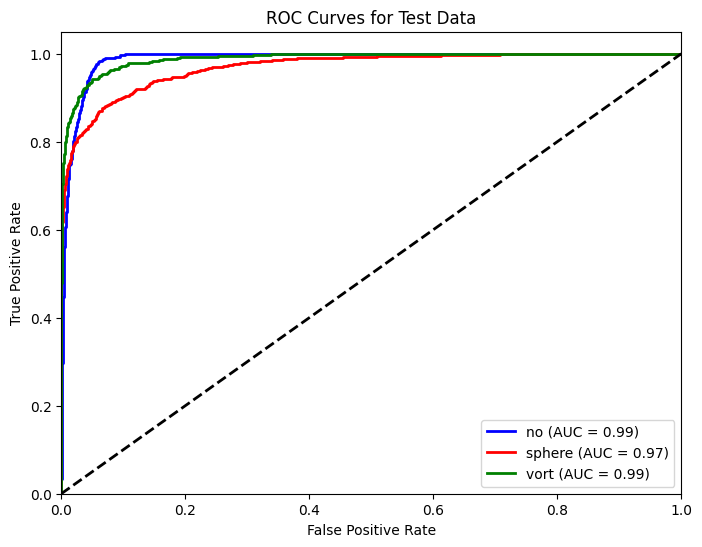

AUC for no: 0.99
AUC for sphere: 0.97
AUC for vort: 0.99


In [207]:
# Evaluate on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)[0]
        probs = F.softmax(outputs, dim=1)
        all_preds.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Binarize labels for multi-class ROC
n_classes = 3
y_test = label_binarize(all_labels, classes=[0, 1, 2])
fpr, tpr, roc_auc = {}, {}, {}

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], all_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
class_names = ['no', 'sphere', 'vort']  # Adjust based on your dataset
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Test Data')
plt.legend(loc="lower right")
plt.show()

# Print AUC scores
for i, class_name in enumerate(class_names):
    print(f"AUC for {class_name}: {roc_auc[i]:.2f}")

In [208]:
# Print AUC scores
for i, class_name in enumerate(class_names):
    print(f"AUC for {class_name}: {roc_auc[i]:.2f}")

AUC for no: 0.99
AUC for sphere: 0.97
AUC for vort: 0.99
